In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
import shap
import joblib
import hopsworks
import optuna
import warnings
warnings.filterwarnings('ignore')


### Connecting to Feature store and loading data

In [16]:
project = hopsworks.login(
    project="aqi_prediction72",
    api_key_file="hopsworks.key"
)

fs = project.get_feature_store()
feature_view = fs.get_feature_view("aqi_prediction_online",version=1)
print("FV OK:", feature_view.name, feature_view.version)

print("Creating training dataset")

td_version,td_job = feature_view.create_train_test_split(
    test_size=0.2,
    random_state=42,
    description="AQI Prediction Training dataset"
)
print(f"Training dataset created successfully! Version: {td_version}")
X_train,X_test,y_train,y_test = feature_view.get_train_test_split(
training_dataset_version=td_version,
test_size=0.2,
random_state=42
)


print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


2025-10-13 16:24:44,062 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-10-13 16:24:44,070 INFO: Initializing external client
2025-10-13 16:24:44,072 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-10-13 16:24:47,102 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1257622
FV OK: aqi_prediction_online 1
Creating training dataset
Training dataset job started successfully, you can follow the progress at 
http://c.app.hopsworks.ai/p/1257622/jobs/named/aqi_prediction_online_1_create_fv_td_13102025112503/executions
2025-10-13 16:25:13,660 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-10-13 16:25:16,938 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-10-13 16:31:33,064 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-10-13 16:31:33,371 INFO: Waiting for lo

### Preprocesssing Data

In [18]:
drop_cols = [c for c in ['timestamp','aqi','ts_epoch_ms'] if c in X_train.columns]
feature_columns = [c for c in X_train.columns if c not in drop_cols]

X_train_features = X_train[feature_columns].copy()
X_test_features  = X_test[feature_columns].copy()

#Handling NaNs
X_train_clean = X_train_features.fillna(X_train_features.mean(numeric_only=True))
X_test_clean  = X_test_features.fillna(X_test_features.mean(numeric_only=True))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test_clean)

print("Data Preprocessing Complete")

Data Preprocessing Complete


### Model Eval Function

In [19]:
def evaluate_model(y_true,y_pred,model_name):
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    mae = mean_absolute_error(y_true,y_pred)
    r2 = r2_score(y_true,y_pred)
    
    print(f"{model_name} Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print("\n")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

model_results = {}
trained_models = {}

print("Evaluation function ready")
    

Evaluation function ready


### Random Forest

In [20]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth = 15,
    min_samples_split = 5,
    min_samples_leaf = 2,
    random_state = 42,
    n_jobs = -1
)


rf.fit(X_train_clean,y_train)
rf_predictions = rf.predict(X_test_clean)

rf_results = evaluate_model(y_test,rf_predictions,"Random Forest")
model_results['Random Forest'] = rf_results
trained_models['Random Forest'] = rf

print("Random Forest Training Complete")

Random Forest Performance:
RMSE: 0.7766
MAE: 0.1348
R2 Score: 0.9999


Random Forest Training Complete


### Ridge Regression

In [21]:
ridge = Ridge(
    alpha=1.0,
    random_state=42
)

ridge.fit(X_train_scaled,y_train)
ridge_predictions = ridge.predict(X_test_scaled)

ridge_results = evaluate_model(y_test,ridge_predictions,"Ridge Regression")
model_results['Ridge Regression'] = ridge_results
trained_models['Ridge Regression'] = ridge

print("Ridge Regression Training Complete")

Ridge Regression Performance:
RMSE: 0.0334
MAE: 0.0190
R2 Score: 1.0000


Ridge Regression Training Complete


### XGBoost

In [25]:
xgb = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train_clean, y_train)
xgb_predictions = xgb.predict(X_test_clean)
xgb_results = evaluate_model(y_test,xgb_predictions,"XGBoost")
model_results['XGBoost'] = xgb_results
trained_models['XGBoost'] = xgb

print("XGBoost training completed")

XGBoost Performance:
RMSE: 1.0574
MAE: 0.6710
R2 Score: 0.9998


XGBoost training completed


### LightGBM

In [26]:
lgb = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb.fit(X_train_clean,y_train)
lgb_predictions = lgb.predict(X_test_clean)
lgb_results = evaluate_model(y_test,lgb_predictions,"LightGBM")
model_results['LightGBM'] = lgb_results
trained_models['LightGBM'] = lgb

print("LightGBM training completed")

LightGBM Performance:
RMSE: 1.1256
MAE: 0.5668
R2 Score: 0.9998


LightGBM training completed


### Pytorch NN

In [27]:
class AQIPredictor(nn.Module):
    def __init__(self,input_size):
        super(AQIPredictor,self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values.reshape(-1, 1))
X_test_tensor = torch.FloatTensor(X_test_scaled)
input_size = X_train_scaled.shape[1]
pytorch_model = AQIPredictor(input_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(pytorch_model.parameters(),lr=0.001)
epochs = 1000
pytorch_model.train()

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = pytorch_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        
pytorch_model.eval()
with torch.no_grad():
    pytorch_predictions = pytorch_model(X_test_tensor).numpy().flatten()
pytorch_results = evaluate_model(y_test,pytorch_predictions,"PyTorch Neural Network")
model_results['PyTorch Neural Network'] = pytorch_results
trained_models['PyTorch Neural Network'] = pytorch_model

print("PyTorch Neural Network training completed")

Epoch [50/1000], Loss: 20752.2852
Epoch [100/1000], Loss: 2086.4358
Epoch [150/1000], Loss: 753.7938
Epoch [200/1000], Loss: 520.9980
Epoch [250/1000], Loss: 434.3670
Epoch [300/1000], Loss: 413.3794
Epoch [350/1000], Loss: 368.1371
Epoch [400/1000], Loss: 338.0363
Epoch [450/1000], Loss: 328.3641
Epoch [500/1000], Loss: 310.8354
Epoch [550/1000], Loss: 296.4078
Epoch [600/1000], Loss: 279.0268
Epoch [650/1000], Loss: 260.9237
Epoch [700/1000], Loss: 259.6609
Epoch [750/1000], Loss: 250.8658
Epoch [800/1000], Loss: 260.0706
Epoch [850/1000], Loss: 249.1973
Epoch [900/1000], Loss: 232.3753
Epoch [950/1000], Loss: 229.2100
Epoch [1000/1000], Loss: 237.6593
PyTorch Neural Network Performance:
RMSE: 6.6811
MAE: 5.1048
R2 Score: 0.9925


PyTorch Neural Network training completed


### Results

In [28]:
comparison_df = pd.DataFrame(model_results).T
comparison_df = comparison_df.round(4)

print(comparison_df)

best_rmse = comparison_df['RMSE'].min()
best_mae = comparison_df['MAE'].min()
best_r2 = comparison_df['R2'].max()

best_rmse_model = comparison_df[comparison_df['RMSE'] == best_rmse].index[0]
best_mae_model = comparison_df[comparison_df['MAE'] == best_mae].index[0]
best_r2_model = comparison_df[comparison_df['R2'] == best_r2].index[0]

print(f"\nBest Models:")
print(f"Lowest RMSE: {best_rmse_model} ({best_rmse:.4f})")
print(f"Lowest MAE:  {best_mae_model} ({best_mae:.4f})")
print(f"Highest R2:  {best_r2_model} ({best_r2:.4f})")

comparison_df.to_csv('../models/model_comparison.csv')
print(f"Model comparison saved to models/model_comparison.csv")



                          RMSE     MAE      R2
Random Forest           0.7766  0.1348  0.9999
Ridge Regression        0.0334  0.0190  1.0000
XGBoost                 1.0574  0.6710  0.9998
LightGBM                1.1256  0.5668  0.9998
PyTorch Neural Network  6.6811  5.1048  0.9925

Best Models:
Lowest RMSE: Ridge Regression (0.0334)
Lowest MAE:  Ridge Regression (0.0190)
Highest R2:  Ridge Regression (1.0000)
Model comparison saved to models/model_comparison.csv


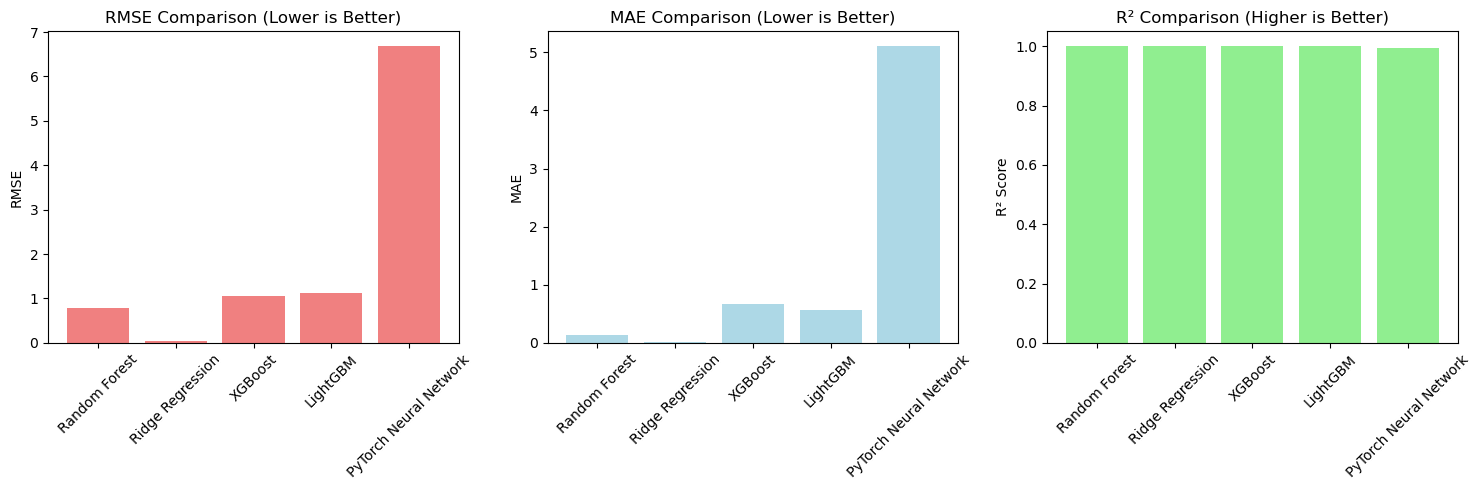

Model comparison visualization completed


In [29]:

fig,axes = plt.subplots(1,3,figsize=(15,5))

axes[0].bar(comparison_df.index,comparison_df['RMSE'],color='lightcoral')
axes[0].set_title('RMSE Comparison (Lower is Better)')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x',rotation=45)
axes[1].bar(comparison_df.index,comparison_df['MAE'],color='lightblue')
axes[1].set_title('MAE Comparison (Lower is Better)')
axes[1].set_ylabel('MAE')
axes[1].tick_params(axis='x',rotation=45)
axes[2].bar(comparison_df.index,comparison_df['R2'],color='lightgreen')
axes[2].set_title('R² Comparison (Higher is Better)')
axes[2].set_ylabel('R² Score')
axes[2].tick_params(axis='x',rotation=45)

plt.tight_layout()
plt.show()

print("Model comparison visualization completed")

### Saving best model to Hopsworks Model Registry

In [30]:
mr = project.get_model_registry()

best_model = trained_models['Ridge Regression']
joblib.dump(best_model,'../models/ridge_regression_best.pkl')
joblib.dump(scaler,"../models/scaler.pkl")
print("Best model saved locally")

try:
    ridge_model_registry = mr.sklearn.create_model(
        name = "aqi_ridge_regression",
        version = 3,
        description = "Best Performing AQI Prediction Model - Ridge Regression"
    )
    ridge_model_registry.save("../models")
    print("Model saved to Hopsworks Model Registry")
except Exception as e:
    print(f"Error saving model to Hopsworks Model Registry: {e}")
    
print(f"Best model: Ridge Regression")
print(f"RMSE: {ridge_results['RMSE']:.4f}")
print(f"MAE: {ridge_results['MAE']:.4f}")
print(f"R2: {ridge_results['R2']:.4f}")

Best model saved locally


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading e:\10Pearls\aqi_prediction_project\notebooks\../models/model_comparison.csv: 0.000%|          | 0/19…

Uploading e:\10Pearls\aqi_prediction_project\notebooks\../models/ridge_regression_best.pkl: 0.000%|          |…

Uploading e:\10Pearls\aqi_prediction_project\notebooks\../models/scaler.pkl: 0.000%|          | 0/2375 elapsed…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1257622/models/aqi_ridge_regression/3
Model saved to Hopsworks Model Registry
Best model: Ridge Regression
RMSE: 0.0334
MAE: 0.0190
R2: 1.0000
